# Reducing hospital readmissions
*[A DataCamp challenge](https://www.datacamp.com)*

![](img/hospital-patient-readmissions.jpg)


May, 2023
> *Predictive Analytics, ML —classification*

## The project
You work for a consulting company helping a hospital group better understand patient readmissions. The hospital gave you access to ten years of information on patients readmitted to the hospital after being discharged. The doctors want you to assess if initial diagnoses, number of procedures, or other variables could help them better understand the probability of readmission. 

They want to focus follow-up calls and attention on those patients with a higher probability of readmission.

- What is the most common primary diagnosis by age group?
- Some doctors believe diabetes might play a central role in readmission. Explore the effect of a diabetes diagnosis on readmission rates.
- On what groups of patients should the hospital focus their follow-up efforts to better monitor patients with a high probability of readmission?


You have access to ten years of patient information ([source](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008)):


| Column     | Description              |
|------------|--------------------------|
| `age` | age bracket of the patient|
| `time_in_hospital` | days (from 1 to 14)|
| `n_procedures` | number of procedures performed during the hospital stay|
| `n_lab_procedures` | number of laboratory procedures performed during the hospital stay|
| `n_medicationsv` | number of medications administered during the hospital stay|
| `n_outpatient` | number of outpatient visits in the year before a hospital stay|
| `n_inpatient` | number of inpatient visits in the year before the hospital stay|
| `n_emergency` | number of visits to the emergency room in the year before the hospital stay|
| `medical_specialty` | the specialty of the admitting physician|
| `diag_1` | primary diagnosis (Circulatory, Respiratory, Digestive, etc.)|
| `diag_2` | secondary diagnosis|
| `diag_3` | additional secondary diagnosis|
| `glucose_test` | whether the glucose serum came out as high (> 200), normal, or not performed|
| `A1Ctest` | whether the A1C level of the patient came out as high (> 7%), normal, or not performed|
| `change` | whether there was a change in the diabetes medication ('yes' or 'no')|
| `diabetes_med` | whether a diabetes medication was prescribed ('yes' or 'no')|
| `readmitted` | if the patient was readmitted at the hospital ('yes' or 'no') |

***Acknowledgments**: Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore, "Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records," BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014.*

## Data validation

### Read the data

In [203]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score
from scipy.stats.mstats import winsorize
import my_functions as my

# Read the data from file
hospital = pd.read_csv('data/hospital_readmissions.csv')
print(hospital)

           age  time_in_hospital  n_lab_procedures  n_procedures  \
0      [70-80)                 8                72             1   
1      [70-80)                 3                34             2   
2      [50-60)                 5                45             0   
3      [70-80)                 2                36             0   
4      [60-70)                 1                42             0   
...        ...               ...               ...           ...   
24995  [80-90)                14                77             1   
24996  [80-90)                 2                66             0   
24997  [70-80)                 5                12             0   
24998  [70-80)                 2                61             3   
24999  [50-60)                10                37             1   

       n_medications  n_outpatient  n_inpatient  n_emergency  \
0                 18             2            0            0   
1                 13             0            0        

### Check data integrity

In [180]:
# Dataframe info
hospital.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             25000 non-null  object
 15  diabetes_med       25000 non-null  object
 16  readmitted         25000 non-null  objec

We can see that there are no missing values.

In [181]:
# Look for duplicated rows
hospital.duplicated().sum()

0

There are also no duplicated rows.

### Check categorical variables

Let's see if variables of type 'object' (strings) contain categories.

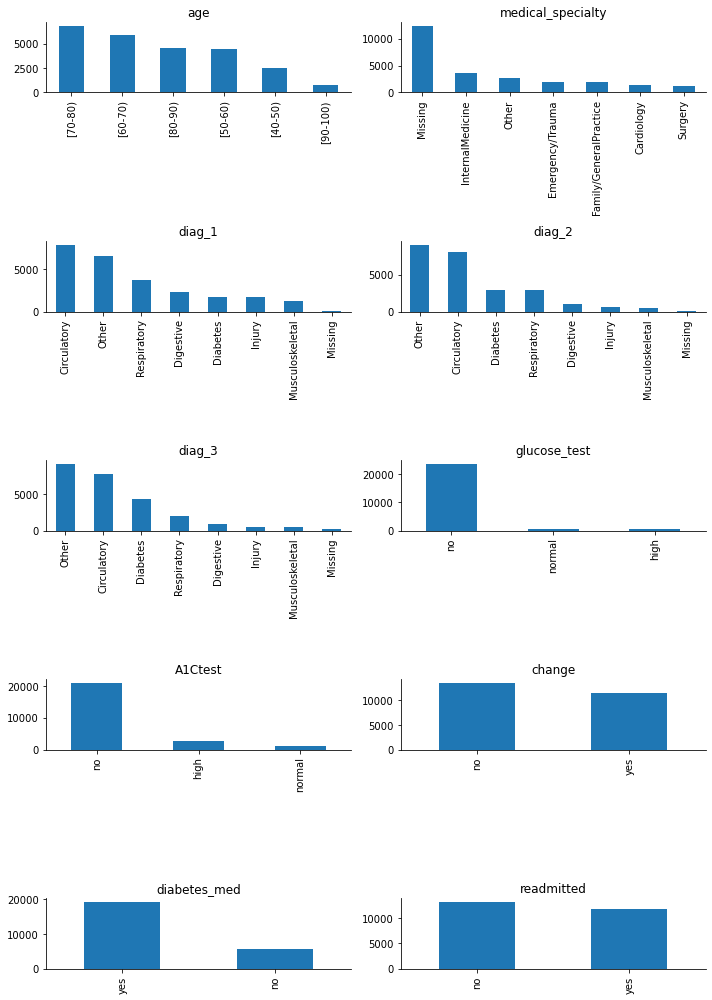

In [182]:
# Select column names of object type
object_cols = hospital.select_dtypes(include="object").columns

# Plot their values and counts
fig, ax= plt.subplots(int(len(object_cols) / 2), 2, figsize=(10, 14))
i = 0
for col in object_cols:
    x = int(i / 2)
    y = i % 2
    sns.despine()
    hospital[col].value_counts().plot(ax=ax[x, y], kind='bar')
    ax[x, y].set_title(col)
    i += 1

fig.tight_layout()
plt.show()  

All of them are categorical variables.

The target variable, 'readmitted', is quite balanced, with the class of interest, 'yes', being well-represented and almost equal to the other class. I am going to replace the values in the target variable from 'no-yes' to numerical '0-1' right away (without waiting for the creation of dummies) because it will facilitate some early analysis.

In [183]:
# Replace to numerical values
hospital['readmitted'] = hospital['readmitted'].replace({'no': 0, 'yes': 1}).astype('int32')

The number of values in the 'Missing' category for variables 'diag_1', 'diag_2', and 'diag_3' is low, so I will assign them to the 'Other' category to reduce dimensionality.

In [184]:
# Assign values
hospital.loc[hospital['diag_1'] == 'Missing', 'diag_1'] = 'Other'
hospital.loc[hospital['diag_2'] == 'Missing', 'diag_2'] = 'Other'
hospital.loc[hospital['diag_3'] == 'Missing', 'diag_3'] = 'Other'

All the remaining 'object' columns can be converted to categorical.

In [185]:
# Create a dictionary of column and data type mappings
conversion_dict = {k: "category" for k in hospital.select_dtypes(include="object").columns}

# Convert our DataFrame and check the data types
hospital = hospital.astype(conversion_dict)
hospital.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                25000 non-null  category
 1   time_in_hospital   25000 non-null  int64   
 2   n_lab_procedures   25000 non-null  int64   
 3   n_procedures       25000 non-null  int64   
 4   n_medications      25000 non-null  int64   
 5   n_outpatient       25000 non-null  int64   
 6   n_inpatient        25000 non-null  int64   
 7   n_emergency        25000 non-null  int64   
 8   medical_specialty  25000 non-null  category
 9   diag_1             25000 non-null  category
 10  diag_2             25000 non-null  category
 11  diag_3             25000 non-null  category
 12  glucose_test       25000 non-null  category
 13  A1Ctest            25000 non-null  category
 14  change             25000 non-null  category
 15  diabetes_med       25000 non-null  category
 16  read

We can see that the memory usage has been reduced by half.

### Check numerical variables

I will plot histograms for them to get a sense of their value ranges.

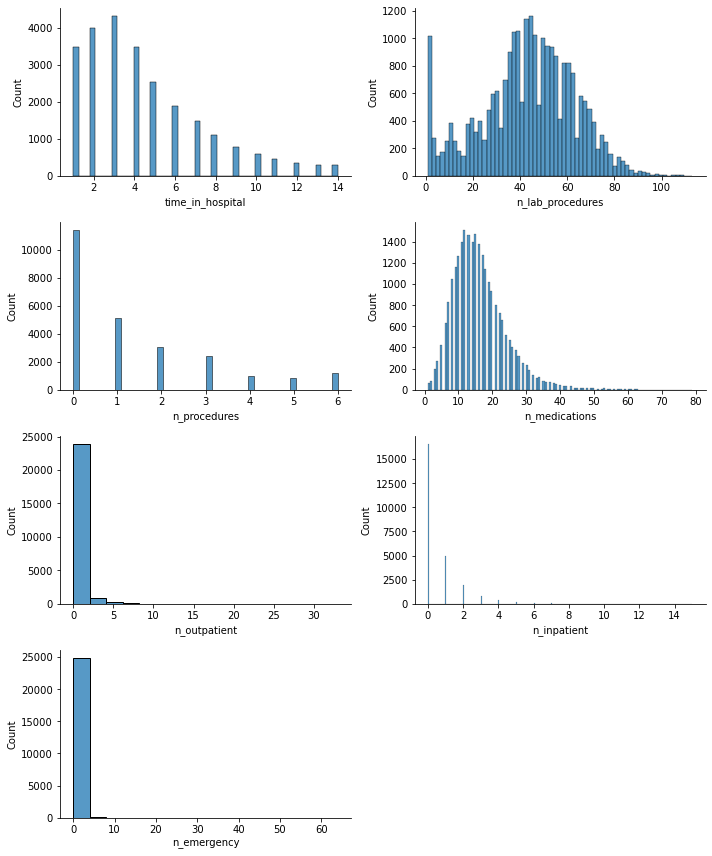

In [186]:
# Select numerical columns to plot
num_cols_check = hospital.select_dtypes(include='int64')

# Plot numerical columns' data distributions
fig, ax= plt.subplots(4, 2, figsize=(10, 12))
i = 0
for col in num_cols_check:
    x = int(i / 2)
    y = i % 2
    sns.despine()
    sns.histplot(hospital[col], ax=ax[x, y])
    i += 1

ax[3, 1].axis('off')
fig.tight_layout()
plt.show()

It appears that there may be some outliers. I will check this by creating a box plot, which will also help me to see more clearly that these numerical values are of the same order of magnitude.

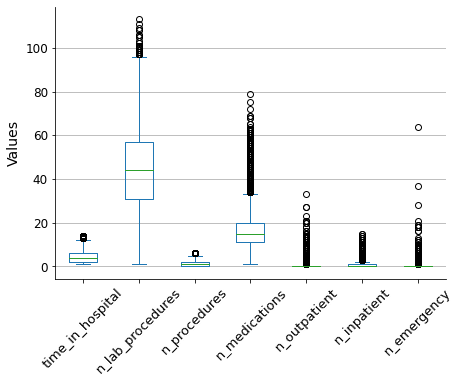

In [187]:
# Plot
fig, ax = plt.subplots(figsize=(7, 5))

hospital[hospital.select_dtypes(include='int64').columns].plot(ax=ax, kind='box')

sns.despine()
ax.grid(axis="y")
ax.set_axisbelow(True)

ax.set_ylabel('Values', fontsize=14)

ax.tick_params(axis='x', labelsize=13, rotation=45)
ax.tick_params(axis='y', labelsize=12)

plt.show()

To reduce the impact of outliers on the model outcome, I will use the winsorization method to filter them out. This will limit the extreme values to lower and upper limits based on percentiles. I will use a 5% limit for both the upper and lower bounds.

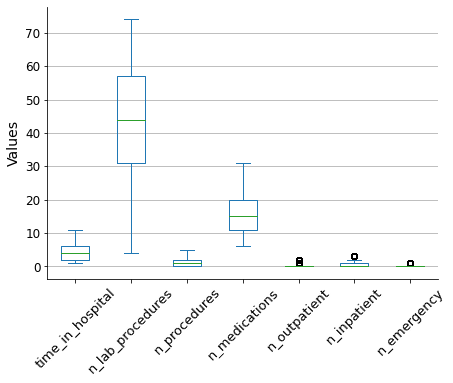

In [188]:
# Filter outliers with winsorization
limit = 0.05
for col in hospital.select_dtypes(include='int64').columns:
    hospital[col] = winsorize(hospital[col], limits = [limit, limit])
    
# Plot resulting box plot
fig, ax = plt.subplots(figsize=(7, 5))

hospital[hospital.select_dtypes(include='int64').columns].plot(ax=ax, kind='box')

sns.despine()
ax.grid(axis="y")
ax.set_axisbelow(True)

ax.set_ylabel('Values', fontsize=14)

ax.tick_params(axis='x', labelsize=13, rotation=45)
ax.tick_params(axis='y', labelsize=12)

plt.show()

## Data analysis

I will answer each of the three questions that were asked.

### Q1: *What is the most common primary diagnosis by age group?*

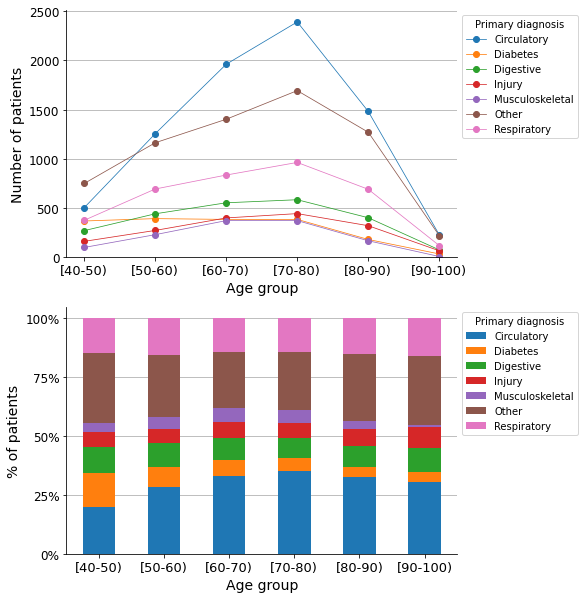

In [189]:
# Plot
fig, ax = plt.subplots(2, 1, figsize=(7, 10))
sns.despine()

hospital.groupby('age')['diag_1'].value_counts()\
        .unstack().plot(ax=ax[0], marker='o', linewidth=0.75)

hospital.groupby('age')['diag_1'].value_counts(normalize=True)\
        .unstack().plot(ax=ax[1], kind='bar', stacked=True)

for i in range(2):
    ax[i].grid(axis="y")
    ax[i].set_axisbelow(True)
    
    ax[i].set_xlabel('Age group', fontsize=14)
    
    ax[i].tick_params(axis='x', labelsize=13, rotation=0)
    ax[i].tick_params(axis='y', labelsize=12)
    
    ax[i].set_ylim(0)
    ax[i].legend(title='Primary diagnosis', loc='upper left', bbox_to_anchor=(1, 1))

ax[0].set_ylabel("Number of patients", fontsize=14)
ax[1].set_ylabel("% of patients", fontsize=14)
ax[1].set_yticks(np.arange(0, 1.25, 0.25), labels=['0%', '25%', '50%', '75%', '100%'])

plt.show()

As shown in the graphs, circulatory disease is the most common primary diagnosis across most of the age groups.

### Q2: *What is the effect of a diabetes diagnosis on the rate of readmissions?*

I will begin by plotting the incidence ratio of the variable on the target variable. As I intend to use this type of graph for other variables in the project, I will define a function to create the so-called Predictor Insight Graph, which provides insight into the effect of the predictor variable on the target variable.

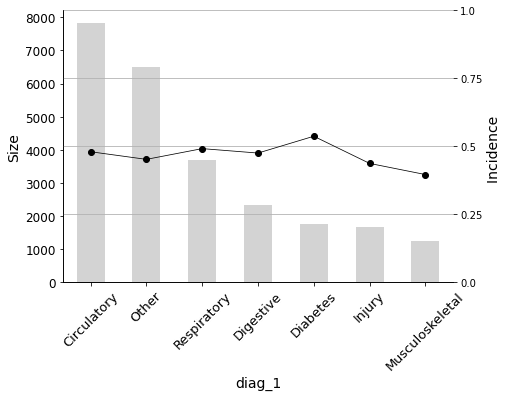

In [190]:
# Define function
def plot_pig(df, variable, target, sort=False, rotation=0):
    '''Create and plot Predictor Insight Graph for corresponding variable'''
    
    # Create Predictor Insight Graph table
    pig_table = df.groupby(variable)[target].agg([np.size, np.mean])
    
    # If sort values
    if sort:
        pig_table = pig_table.sort_values('size', ascending=False)
    
    # Plot
    fig, ax = plt.subplots(figsize=(7, 5))
    ax2 = ax.twinx()
    
    pig_table['size'].plot(ax=ax, kind='bar', color='lightgrey')
    ax2.plot(ax.get_xticks(), pig_table['mean'], marker='o', linewidth=0.75, color='black')
    
    sns.despine()
    ax2.grid(axis="y")
    ax.set_axisbelow(True)
    
    ax.set_title('', fontsize=14)
    ax.set_xlabel(variable, fontsize=14)
    ax.set_ylabel('Size', fontsize=14)
    ax2.set_ylabel('Incidence ', fontsize=14)
    
    ax.tick_params(axis='x', labelsize=13, rotation=rotation)
    ax.tick_params(axis='y', labelsize=12)
    ax2.set_yticks(np.arange(0, 1.25, 0.25), labels=np.arange(0, 1.25, 0.25))
    
    ax.set_ylim(0)
    ax2.set_ylim(0, 1)
    
    plt.show()
    
    return pig_table

# Call the function of the variable of interest
_ = plot_pig(hospital, 'diag_1', 'readmitted', sort=True, rotation=45)

The graph shows that the incidence in the target variable is highest for diabetes as the primary diagnosis.

However, is this difference statistically significant? I will conduct a statistical test to answer this question.

Let's calculate the distributions of the readmision rate for:
1. Patients *with* diabetes as primary diagnosis.
2. Patients *without* diabetes as primary diagnosis.

Readmission rate means:
0.536 <- with diabetes as primary diagnosis
0.465 <- without diabetes as primary diagnosis


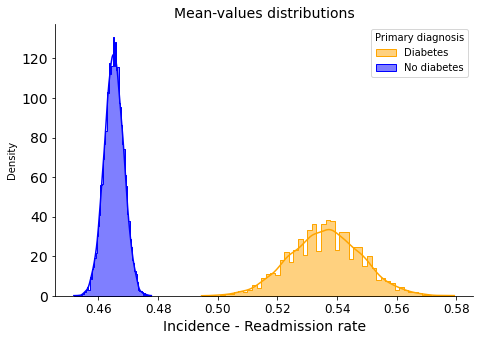

In [191]:
# Create array with readmissions for diabetes as primary diagnosis
diab1 = hospital.loc[hospital['diag_1'] == 'Diabetes', 'readmitted'].to_numpy()

# Create array with readmissions for primary diagnosis not diabetes
diab1_no = hospital.loc[hospital['diag_1'] != 'Diabetes', 'readmitted'].to_numpy()

# Print mean values
print(f'Readmission rate means:')
print(f'{np.mean(diab1):.3f} <- with diabetes as primary diagnosis')
print(f'{np.mean(diab1_no):.3f} <- without diabetes as primary diagnosis')

# Set random number seed
np.random.seed(42)

# Draw bootstrap replicates and store their mean values
bs_reps_diab1 = my.draw_bs_reps(diab1, np.mean, size=10000)
bs_reps_diab1_no = my.draw_bs_reps(diab1_no, np.mean, size=10000)

# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

sns.histplot(bs_reps_diab1, ax=ax, kde=True, stat="density", element="step",
             color="orange", label="Diabetes")
sns.histplot(bs_reps_diab1_no, ax=ax, kde=True, stat="density", element="step",
             color="blue", label="No diabetes")

ax.set_title("Mean-values distributions", size=14)
ax.tick_params(axis='x', labelsize=12, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel("Incidence - Readmission rate", size=14)
ax.legend(title='Primary diagnosis')
sns.despine()
    
plt.show()

There is no overlap, indicating that the difference is likely statistically significant.

Nevertheless, let's perform the hypothesis test. I will assume the null hypothesis that there is no difference between the two groups. To test this, I will shift the distribution values to equalize their means, and then determine how often we could obtain purely by chance the difference in mean values that we are currently observing.

In [192]:
# Compute the difference of means
diff_means = np.mean(diab1) - np.mean(diab1_no)

# Concatenate arrays
diab_concat = np.concatenate((diab1, diab1_no))

# Compute mean of all
mean_diab_concat = np.mean(diab_concat)

# Generate shifted arrays
diab1_shifted = diab1 - np.mean(diab1) + mean_diab_concat
diab1_no_shifted = diab1_no - np.mean(diab1_no) + mean_diab_concat

# Compute 10,000 bootstrap replicates from shifted arrays
bs_reps_diab1_shifted = my.draw_bs_reps(diab1_shifted, np.mean, size=10000)
bs_reps_diab1_no_shifted = my.draw_bs_reps(diab1_no_shifted, np.mean, size=10000)

# Get replicates of difference of means
bs_reps_diff = bs_reps_diab1_shifted - bs_reps_diab1_no_shifted

# Compute p-value
p = np.sum(bs_reps_diff >= diff_means) / len(bs_reps_diff)
print('p-value =', p)

p-value = 0.0


After calculating the mean of 10,000 random bootstrap replicates, we did not observe a single one with the difference in means that we are currently observing. Therefore, we reject the null hypothesis and conclude that the difference is statistically significant. This means that having diabetes as a primary diagnosis certainly has an effect on the rate of readmissions.

Would the effect be the same for these two groups?
1. Patients *with* diabetes as the primary, secondary, or tertiary diagnosis.
2. Patients *without* diabetes in any of their diagnoses.

Readmission rate means:
0.465 <- with diabetes in any diagnosis
0.473 <- without diabetes in all diagnosis


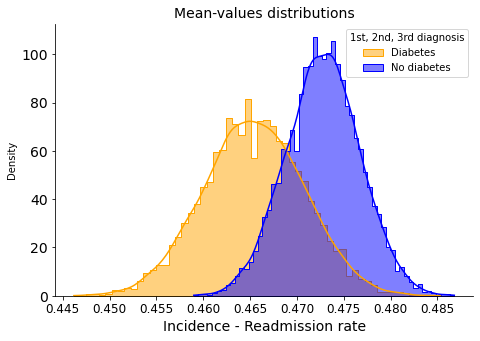

In [193]:
# Array with readmissions for diabetes as primary, secondary or additional diagnosis
diab123 = hospital.loc[(hospital['diag_1'] == 'Diabetes')\
                       | (hospital['diag_2'] == 'Diabetes')\
                       | (hospital['diag_3'] == 'Diabetes'), 'readmitted']\
                    .replace({'no': 0, 'yes': 1}).to_numpy()

# Create array with readmissions for diagnosis not diabetes
diab123_no = hospital.loc[(hospital['diag_1'] != 'Diabetes')\
                       & (hospital['diag_2'] != 'Diabetes')\
                       & (hospital['diag_3'] != 'Diabetes'), 'readmitted']\
                    .replace({'no': 0, 'yes': 1}).to_numpy()

print(f'Readmission rate means:')
print(f'{np.mean(diab123):.3f} <- with diabetes in any diagnosis')
print(f'{np.mean(diab123_no):.3f} <- without diabetes in all diagnosis')

# Set random numbers' seed
np.random.seed(42)

# Draw bootstrap replicates
bs_reps_diab123 = my.draw_bs_reps(diab123, np.mean, size=10000)
bs_reps_diab123_no = my.draw_bs_reps(diab123_no, np.mean, size=10000)

# Plot
fig, ax = plt.subplots(figsize=(7.5, 5))

sns.histplot(bs_reps_diab123, ax=ax, kde=True, stat="density", element="step",
             color="orange", label="Diabetes")
sns.histplot(bs_reps_diab123_no, ax=ax, kde=True, stat="density", element="step",
             color="blue", label="No diabetes")

ax.set_title("Mean-values distributions", size=14)
ax.tick_params(axis='x', labelsize=12, rotation=0)
ax.tick_params(axis='y', labelsize=14)
ax.set_xlabel("Incidence - Readmission rate", size=14)
ax.legend(title='1st, 2nd, 3rd diagnosis')
sns.despine()
    
plt.show()

In this case, when considering secondary and tertiary diagnoses, the overlapping of the distributions suggests that there is no significant difference in readmission rates between patients with and without diabetes.

### Q3: *Identifying patients with a high probability of readmission*
I am going to identify the variables that have the greatest impact on the readmission rate. I will use a simple logistic regression model for the sake of interpretability.

#### Data preprocessing
This process consists of:
1. Separating variables (features) and target.
2. Converting categorical variables to numerical (avoiding multicollinearity).
3. Splitting the data into training and testing sets.
4. Scaling the data (necessary for Logistic Regression).
5. Reconstructing complete basetables (features + target) to perform predictive analysis.

In [194]:
# Define features
features = hospital.drop(['readmitted'], axis=1)

# Define target
target = hospital['readmitted']

# Prepare features encoding categorical variables
X = pd.get_dummies(features,
                   drop_first=True) # Avoid multicollinearity

# Assign target
y = target

# Split dataset into 70% training and 30% test set, and stratify
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

# Scale X
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Reset index to concatenate later
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Create the train and test basetables
train = pd.concat([X_train_scaled, y_train], axis=1)
test = pd.concat([X_test_scaled, y_test], axis=1)

#### Variable selection
Once we have the train and test basetables ready, we can proceed with the process of selecting the variables that have the highest predictive power.

To do so, I will use a *forward stepwise variable selection procedure*, in which AUC scores are considered as a metric. Variables will be sorted according to the predictive power achieved if we include them progressively in a Logistic Regression model. The process will be carried out only in the training basetable to avoid data leakage.

In [195]:
# Define funtion
def auc(variables, target, basetable):
    '''Returns AUC of a Logistic Regression model'''
    X = basetable[variables]
    y = np.ravel(basetable[target])
    logreg = LogisticRegression()
    logreg.fit(X, y)
    predictions = logreg.predict_proba(X)[:,1]
    auc = roc_auc_score(y, predictions)
    return(auc)

# Define funtion
def next_best(current_variables,candidate_variables, target, basetable):
    '''Returns next best variable to maximize AUC'''
    best_auc = -1
    best_variable = None
    for v in candidate_variables:
        auc_v = auc(current_variables + [v], target, basetable)
        if auc_v >= best_auc:
            best_auc = auc_v
            best_variable = v
    return best_variable

# Define funtion
def auc_train_test(variables, target, train, test):
    '''Returns AUC of train and test data sets'''
    return (auc(variables, target, train), auc(variables, target, test))


# Define candidate variables
candidate_variables = list(train.columns)
candidate_variables.remove("readmitted")

# Initialize current variables
current_variables = []

# The forward stepwise variable selection procedure
number_iterations = len(candidate_variables) # All variables will be considered

for i in range(0, number_iterations):
    # Get next variable which maximizes AUC in the training data set
    next_variable = next_best(current_variables, candidate_variables, ["readmitted"], train)
    # Add it to the list
    current_variables = current_variables + [next_variable]
    # Remove it from the candidate variables' list
    candidate_variables.remove(next_variable)
    # Print which variable was added
    print(f"Step {i + 1}: variable '{next_variable}' added")

Step 1: variable 'n_inpatient' added
Step 2: variable 'n_outpatient' added
Step 3: variable 'diabetes_med_yes' added
Step 4: variable 'time_in_hospital' added
Step 5: variable 'n_emergency' added
Step 6: variable 'age_[80-90)' added
Step 7: variable 'age_[70-80)' added
Step 8: variable 'medical_specialty_Surgery' added
Step 9: variable 'medical_specialty_Other' added
Step 10: variable 'medical_specialty_InternalMedicine' added
Step 11: variable 'n_procedures' added
Step 12: variable 'diag_1_Diabetes' added
Step 13: variable 'A1Ctest_normal' added
Step 14: variable 'diag_2_Injury' added
Step 15: variable 'n_medications' added
Step 16: variable 'diag_3_Other' added
Step 17: variable 'n_lab_procedures' added
Step 18: variable 'age_[60-70)' added
Step 19: variable 'diag_1_Other' added
Step 20: variable 'diag_1_Injury' added
Step 21: variable 'diag_1_Musculoskeletal' added
Step 22: variable 'diag_1_Respiratory' added
Step 23: variable 'medical_specialty_Emergency/Trauma' added
Step 24: vari

We will now visualize the performance evolution as variables are included in the model in the order defined by the list. We will consider both the train and test basetables to check the validity of the results.

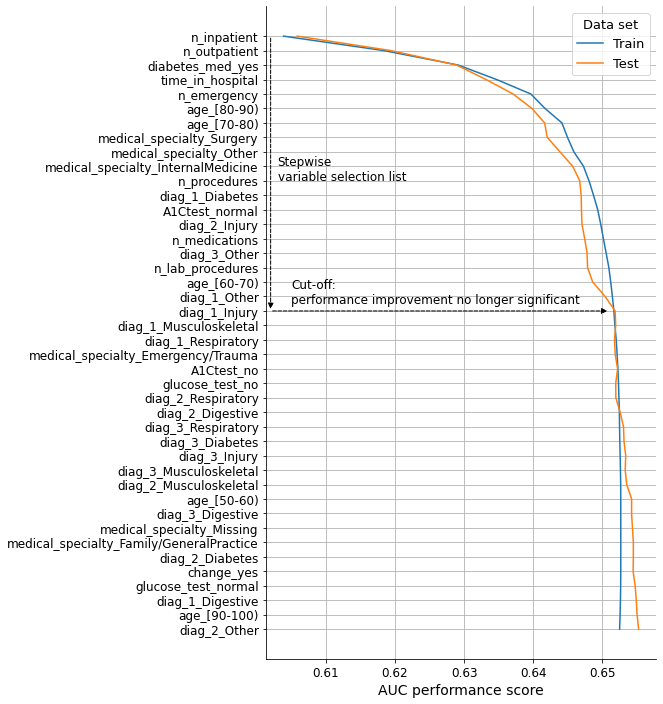

In [196]:
# Init lists
auc_values_train = []
auc_values_test = []
variables_evaluate = []

# Iterate over the variables in variables
for v in current_variables:
  
    # Add the variable
    variables_evaluate.append(v)
    
    # Calculate the train and test AUC of this set of variables
    auc_train, auc_test = auc_train_test(variables_evaluate, ["readmitted"], train, test)
    
    # Append the values to the lists
    auc_values_train.append(auc_train)
    auc_values_test.append(auc_test)

# Create dataframe to plot results
aucs = pd.concat([pd.DataFrame(np.array(auc_values_train),
                               columns=['Train'],
                               index=current_variables),
                  pd.DataFrame(np.array(auc_values_test),
                               columns=['Test'],
                               index=current_variables)],
                 axis=1)

# Plot
fig, ax = plt.subplots(figsize=(7, 12))

ax.plot(aucs['Train'], aucs.index, label='Train')
ax.plot(aucs['Test'], aucs.index, label='Test')

sns.despine()
ax.grid(axis="both")
ax.set_axisbelow(True)

ax.set_title('', fontsize=14)
ax.set_xlabel('AUC performance score', fontsize=14)
ax.set_ylabel("", fontsize=14)

ax.tick_params(axis='x', labelsize=12, rotation=0)
ax.tick_params(axis='y', labelsize=12)

ax.legend(title='Data set', loc='upper right', title_fontsize=13, fontsize=13)

ax.annotate('',
            xy=(0.602, 19),
            xytext=(0.602, 0), fontsize=12,
            arrowprops={"arrowstyle":"-|>", "color":"black", 'linestyle':"--"})

ax.annotate('',
            xy=(0.651, 19), 
            xytext=(0.602, 19), fontsize=12,
            arrowprops={"arrowstyle":"-|>", "color":"black", 'linestyle':"--"})

ax.annotate("Stepwise\nvariable selection list", (0.603, 10), size=12)
ax.annotate("Cut-off:\nperformance improvement no longer significant", (0.605, 18.5), size=12)

ax.invert_yaxis()

plt.show()

# Selected variables
n_variables = 19
selected_variables = current_variables[:n_variables]

After conducting the forward stepwise variable selection procedure, a total of 20 variables were selected based on their predictive power. To ensure that we are not missing any important variables, I will compare the accuracy, precision, and recall scores of the Logistic Regression model when fitted with all variables and when fitted only with the 20 selected ones.

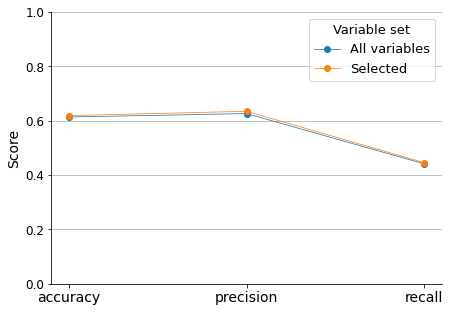

In [197]:
# Fit Logistic Regression model with all variables
scores_all = []
logreg_all = LogisticRegression()
logreg_all.fit(X_train_scaled, y_train)
y_pred_all = logreg_all.predict(X_test_scaled)
scores_all.append(accuracy_score(y_test, y_pred_all))
scores_all.append(precision_score(y_test, y_pred_all))
scores_all.append(recall_score(y_test, y_pred_all))

# Fit Logistic Regression model with selected variables only
scores_sel = []
logreg_sel = LogisticRegression()
logreg_sel.fit(X_train_scaled.loc[:, selected_variables], y_train)
y_pred_sel = logreg_sel.predict(X_test_scaled.loc[:, selected_variables])
scores_sel.append(accuracy_score(y_test, y_pred_sel))
scores_sel.append(precision_score(y_test, y_pred_sel))
scores_sel.append(recall_score(y_test, y_pred_sel))

# Create dataframe for plotting
metrics = pd.DataFrame(scores_all,
                       index=['accuracy', 'precision', 'recall'], columns=['all'])
metrics['sel'] = scores_sel

# Plot
fig, ax = plt.subplots(figsize=(7, 5))

metrics.plot(ax=ax, marker='o', linewidth=0.75)

sns.despine()
ax.grid(axis="y")
ax.set_axisbelow(True)

ax.set_title('', fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Score', fontsize=14)

ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=12)
ax.set_xticks(range(0, 3), labels=list(metrics.index))

ax.legend(title='Variable set', labels=['All variables', 'Selected'],
          loc='upper right', title_fontsize=13, fontsize=13)
ax.set_ylim(0, 1)

plt.show()

The model performance results are not impressive, especially regarding recall (sensitivity). Nevertheless, this comparison demonstrates that we are not losing any predictive information if we only consider the selected variables. Additionally, since this project aims to assess the most important predictors, we will not attempt to optimize the model results.

We will focus instead on the predictive power of the selected variables to try to gain insight about which factors contribute the most to readmissions in the hospital.

Coefficients of the Logistic Regression model tell us about the importance of each variable.

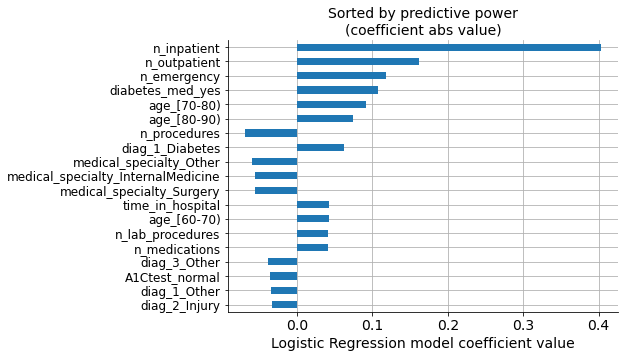

In [198]:
# Extract coefficients of the model fitted with selected variables
coefs = pd.DataFrame(logreg_sel.coef_[0],
                    index=X_train_scaled.loc[:, selected_variables].columns)\
                    .rename(columns={0: 'logreg_coef'})

# Add new column with their absolute value
coefs['coef_abs'] = coefs['logreg_coef'].abs()

# Sort data frame according to the absolute values
coefs = coefs.sort_values('coef_abs', ascending=False)

# Add new column with their position in the model coefficients list
coefs['coef_abs_pos'] = range(1, len(coefs) + 1)

# Plot
fig, ax = plt.subplots(figsize=(7, 5))

coefs['logreg_coef'].plot(kind='barh')

sns.despine()
ax.grid(axis="both")
ax.set_axisbelow(True)

ax.set_title('Sorted by predictive power\n(coefficient abs value)', fontsize=14)
ax.set_xlabel('Logistic Regression model coefficient value', fontsize=14)
ax.set_ylabel('', fontsize=14)

ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=12)

ax.invert_yaxis()

plt.show()

In the graph, we can see the values of the coefficients for each variable, sorted according to their absolute values (predictive power).

However, we selected our own list of variables based on the model performance's progressive improvement. We can see that both lists have the same variables, but the order of importance is not the same.

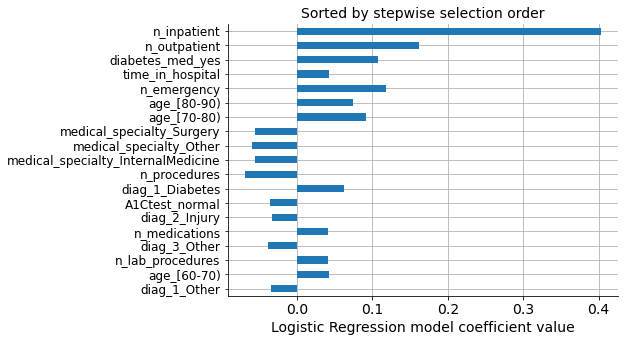

In [199]:
# Create another dataframe with selected variables
sel_vars = pd.DataFrame(selected_variables, columns=['selection'])

# Add column with their position in the selected variable list
sel_vars['selection_pos'] = range(1, len(sel_vars) + 1)

# Set index to prepare for the merging
sel_vars = sel_vars.set_index('selection')

# Merge both dataframes on the indexes
coefs_sels = coefs.merge(sel_vars, how='left', left_index=True, right_index=True)

coefs_sels_ = coefs_sels.sort_values('selection_pos')

# Plot
fig, ax = plt.subplots(figsize=(7, 5))

coefs_sels_['logreg_coef'].plot(kind='barh')

sns.despine()
ax.grid(axis="both")
ax.set_axisbelow(True)

ax.set_title('Sorted by stepwise selection order', fontsize=14)
ax.set_xlabel('Logistic Regression model coefficient value', fontsize=14)
ax.set_ylabel('', fontsize=14)

ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=12)

ax.invert_yaxis()

plt.show()

We can see that the first and second most important variables are the same in both lists, but the third most important coefficient ('n_emergency') does not come in the third position on the selected list. Instead, 'diab_med_yes' was selected, which, in principle, is a variable with less predictive power than 'n_emergency,' as seen in the graph above.

The following graph illustrates these differences in the relative positions.

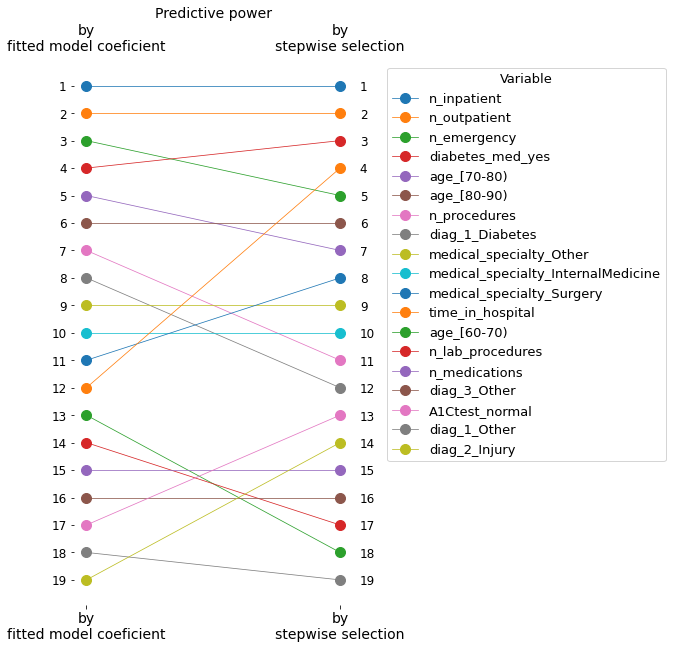

In [200]:
# Select only relative position columns and transpose dataframe for plotting
coefs_sels = coefs_sels[['coef_abs_pos', 'selection_pos']].transpose()

# Plot
fig, ax = plt.subplots(figsize=(5, 10))

coefs_sels.plot(ax=ax, marker='o', markersize=10, linewidth=0.75)

sns.despine(left=True, bottom=True)

ax.set_title('Predictive power', fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('', fontsize=14)

ax.tick_params(axis='x', labelsize=14, rotation=0, labeltop=True)
ax.tick_params(axis='y', labelsize=12, labelright=True)
ax.set_xticks(range(0, 2), labels=['by\nfitted model coeficient', 'by\nstepwise selection'])
ax.set_yticks(range(1, 20), labels=list(range(1, 20)))

ax.invert_yaxis()
ax.legend(title='Variable', loc='upper left', bbox_to_anchor=(1.1, 1),
         title_fontsize=13, fontsize=13)

plt.show()

These differences in the order of importance are due to correlations between variables. I will print the correlation matrix to illustrate this.

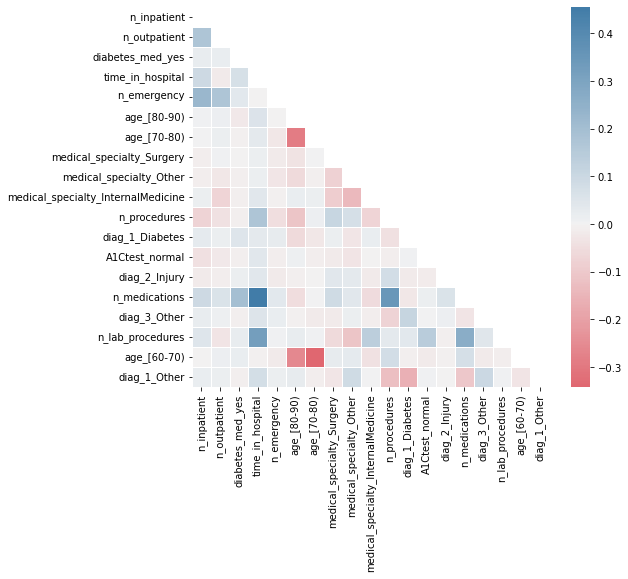

In [201]:
# Get pearson correlation matrix
corr = X_train_scaled.loc[:, selected_variables].corr()

# Plot it with a heatmap
cmap = sns.diverging_palette(h_neg=10, h_pos=240, as_cmap=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(8, 7))

sns.heatmap(corr, ax=ax, mask=mask,
            center=0, cmap=cmap, linewidths=1,
            # annot=True, fmt=".2f"
           )

plt.show()

We can deduce that 'n_emergency' was not included in the third position in the selected list because it has a relatively high correlation with the first two included variables ('n_inpatient' and 'n_outpatient'). Therefore, the stepwise algorithm correctly selects the next most powerful variable, 'diabetes_med_yes'.

The changes in the order of the remaining variables can be explained in a similar way, as they are also influenced by correlations with other variables.

#### Predictor Insight Graphs
Finally, I will plot the Predictor Insight Graphs for the first 12 variables in the selected list, to gain an intuitive sense of their impact on the target.

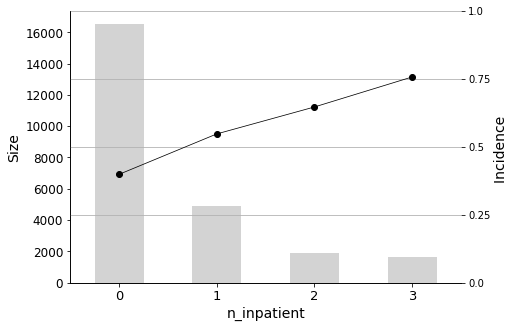

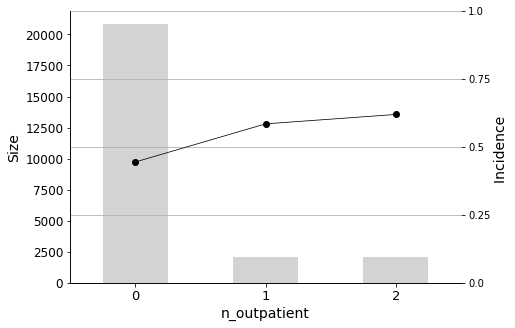

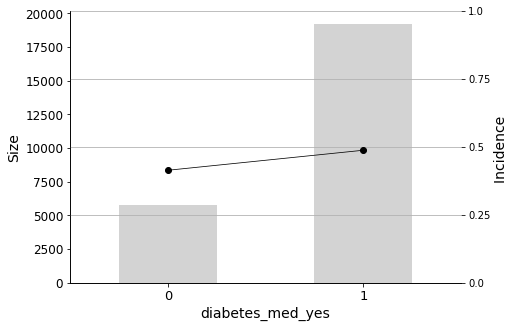

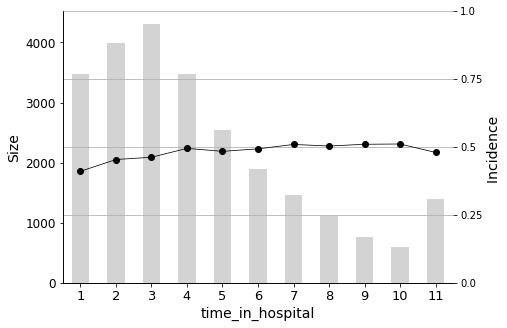

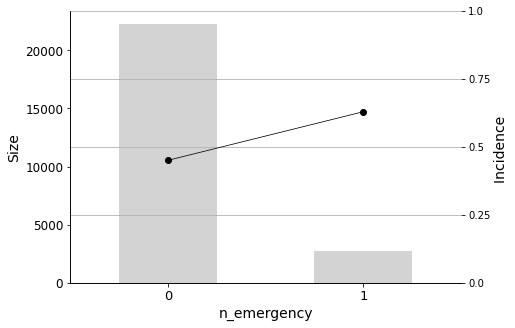

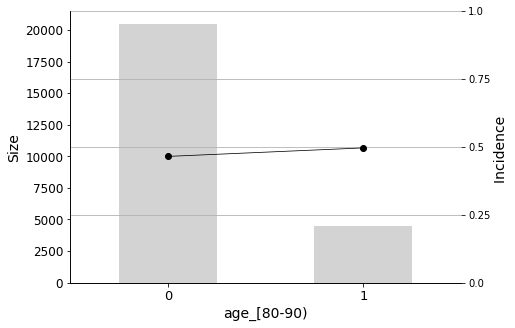

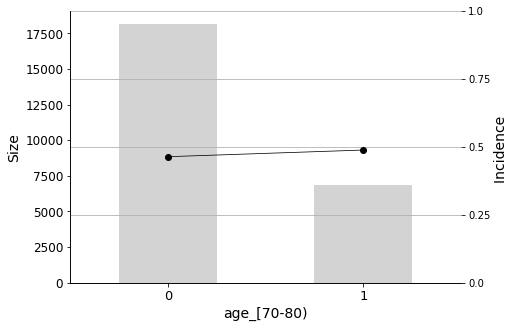

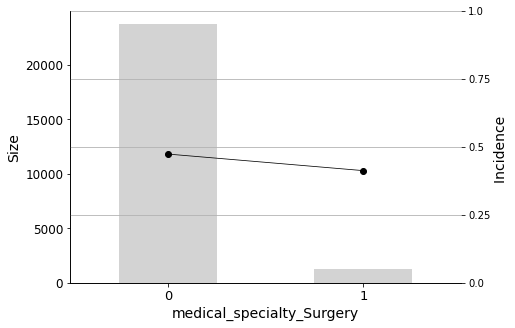

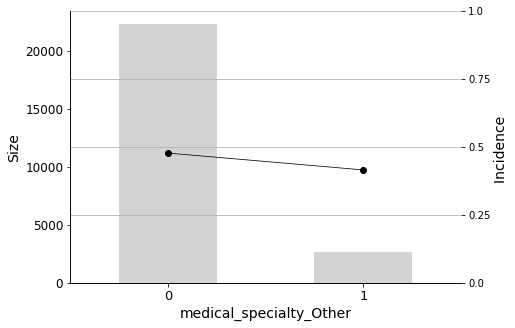

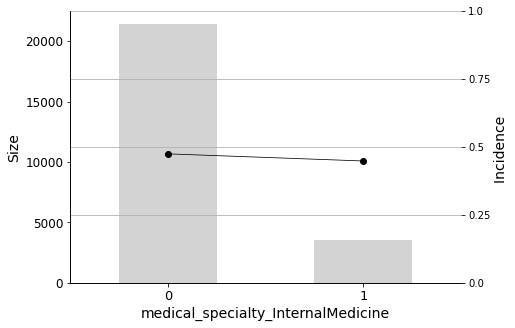

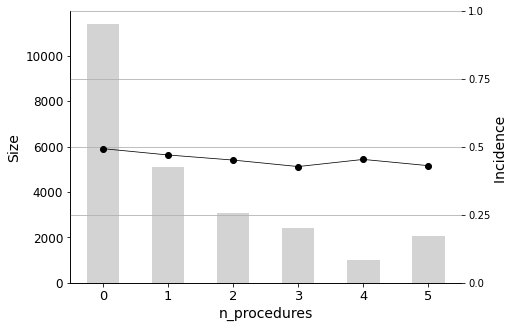

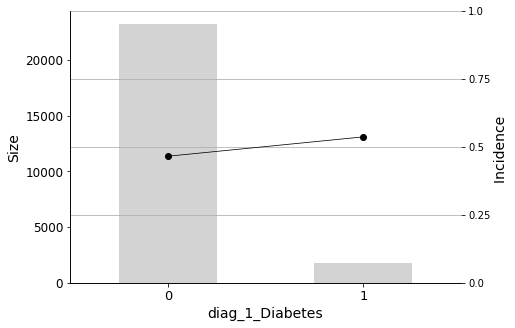

In [202]:
# Reconstruct basetable
hospital_dummied = pd.get_dummies(hospital, drop_first=True)

# Plot
n_plots = 12
for variable in selected_variables[:n_plots]:
    _ = plot_pig(hospital_dummied, variable, 'readmitted')

We will conclude the analysis with this final Predictor Insight Graph, which corresponds to the incidence of diabetes as the primary diagnosis. This graph is the same as the one constructed while answering the second question addressed in this report, with the difference of aggregating all non-diabetes diagnoses. Looking at this graph, it may seem that the incidence (the admission rate) hike is not so high. However, as we learned earlier, it is indeed significant, considering the sizes and corresponding distributions.

Diabetes as the primary diagnosis plays a part, but this variable is in the 12th position in the list. Before it, there are other factors that have more influence on the readmission rate.

## Conclusions
The hospital should focus their follow-up efforts monitoring these patients:
- The most important predictor is **n_inpatient**, which represents the number of inpatient visits in the year before the hospital stay. The readmission rate increases significantly when patients have more inpatient visits prior to their hospital stay, so it is important to closely monitor these individuals. Similarly, **n_outpatient** (the number of outpatient visits in the year before a hospital stay) is also a significant predictor, ranking second in importance.

- In addition to the aforementioned predictors, it is important to look out for patients with a diabetes medication prescribed (**diabetes_med_yes**) as this variable also has significant predictive power for readmission rates.

- Furthermore, the length of stay in the hospital upon admission (**time_in_hospital**) also plays a crucial role. The longer a patient stays in the hospital (from 1 to 14 days), the higher the probability of readmission.

- The number of visits to the emergency room in the year before the hospital stay (**n_emergency**) should also be taken into account. Even a single visit to the emergency room indicates a higher probability of readmission.

- Age, of course, is also an important factor. Patients between the ages of **70-80** and **80-90** are more likely to be readmitted to the hospital.

- Some medical specialties are negatively correlated with readmission. These include **Surgery**, **Internal Medicine**, and **Other**. Therefore, patients admitted by physicians in these specialties have a lower probability of being readmitted.

- The **n_procedures** (number of procedures performed during the hospital stay) is also negatively correlated.

- As doctors' intuition correctly anticipated, having Diabetes as a primary diagnosis (**diag_1_Diabetes**) also has a significant effect on readmission.

And it may also be worth taking a look at the rest of the selected variables. The number of medications (**n_medications**), number of laboratory procedures (**n_lab_procedures**), and age group **60-70** are positively correlated. On the other hand, **A1Ctest_normal**, **diag_2_Injury**, **diag_3_Other**, and **diag_1_Other** are negatively correlated.